In [1]:
using Sloth, DRAW

┌ Info: Recompiling stale cache file /home/ec2-user/.julia/compiled/v1.2/DRAW/AGNCk.ji for DRAW [7e16b5a0-e062-11e9-3467-b7e39d9ee233]
└ @ Base loading.jl:1240
┌ Warning: Package DRAW does not have Sloth in its dependencies:
│ - If you have DRAW checked out for development and have
│   added Sloth as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DRAW
└ Loading Sloth into DRAW from project dependency, future warnings for DRAW are suppressed.


In [1]:
using Knet

In [2]:
mutable struct Corpus
    vocabid
    vocab
end

function Corpus()
    vocabid = Dict()
    vocabid = Dict("" => 1) # both padding and whitespace KnetArray(zeros(EMBEDDING_SIZE))
    vocab = param(reshape(KnetArray{Float32}(zeros(EMBEDDING_SIZE)),(EMBEDDING_SIZE,1)))
    return Corpus(vocabid,vocab)
end

Corpus

In [3]:
mutable struct MultilayerPerceptron
    layers
    MultilayerPerceptron(layers...) = new(layers)
end
(m::MultilayerPerceptron)(x) = (for l in m.layers; x = l(x); end; x)

In [4]:
struct Layer0; w; b; end
Layer0(ir::Int, ic::Int, o::Int) = Layer0(param(o,ir),param0(o, ic))
(l::Layer0)(x) = (l.w * x .+ l.b)

In [5]:
#=
mutable struct EmbedModel
    w
end
=#

In [6]:
#=
function EmbedModel()
    dim1 = 30
    dim2 = 64 #EMBEDDING_SIZE
    dim3 = 32
    w = Param(reshape(KnetArray{Float32}(Knet.xavier(dim1*dim2*dim3)), (1,dim1,dim2,dim3)))
    return EmbedModel(w)
end
=#

In [7]:
#=
function (e::EmbedModel)(x)
    output = conv4(value(e.w), x, dilation=2)
    return output
end
=#

In [8]:
struct ConvModel; w; b; f; end
(c::ConvModel)(x) = c.f.(conv4(c.w, x, dilation=2) .+ c.b)
ConvModel(w1,w2,cx,cy,f=relu) = ConvModel(param(w1,w2,cx,cy), param0(1,2,cy,1), f)

ConvModel

In [9]:
mutable struct CaptionEncoder
    conv_model
    corpus
end

In [10]:
function CaptionEncoder()
    dim1 = 30
    dim2 = 64 #EMBEDDING_SIZE
    dim3 = 32
    conv_model = ConvModel(1,dim1,dim2,dim3)
    corpus = Corpus()
    return CaptionEncoder(conv_model, corpus)
end

CaptionEncoder

In [11]:
function (c::CaptionEncoder)(captions)
    caption_embeds = arrange(captions, c.corpus)
    input = createconvinput(caption_embeds)
    input = reshape(input, (1, MAX_LENGTH, EMBEDDING_SIZE, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE))
    di_hat = c.conv_model(input)
    captions_hat = reshape(reshape(di_hat, (2, 32, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE)), (EMBEDDING_SIZE, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE))
    return captions_hat
end

In [12]:
mutable struct AngleEncoder
    mlp_model
end

In [13]:
function AngleEncoder()
    dim1 = 2 # cos and sin
    dim2 = BATCH_SIZE*NUM_CAPTIONS_PER_SCENE
    dim3 = 32 # from paper
    mlp1=MultilayerPerceptron(Layer0(dim1, dim2, dim3)) # MLP1 dimensionality 32
    return AngleEncoder(mlp1)
end

AngleEncoder

In [14]:
function (a::AngleEncoder)(cameras)
    tuples = build_angles(cameras)
    cameras_hat = a.mlp_model(tuples)
    return cameras_hat
end

In [15]:
#=
mutable struct ImageConvModel
    w
end
=#

In [16]:
#=
function ImageConvModel()
    dim1 = 17
    dim2 = 17
    dim3 = 3 # RGB
    w = reshape(KnetArray{Float32}(Knet.xavier(dim1*dim2*dim3)), (dim1,dim2,dim3,1))
    return ImageConvModel(w)
end
=#

In [17]:
#=
function (i::ImageConvModel)(x)
    output = conv4(i.w, x)
    return output
end
=#

In [18]:
mutable struct ImageConvModel; w; b; f; end
(i::ImageConvModel)(x) = i.f.(conv4(i.w, x) .+ i.b)
ImageConvModel(w1,w2,cx,cy,f=relu) = ImageConvModel(param(w1,w2,cx,cy), param0(16,16,cy,1), f)

ImageConvModel

In [19]:
mutable struct ImageEncoder
    image_conv_model
    sampling_model
end

In [20]:
function ImageEncoder()
    image_conv_model = ImageConvModel(17, 17, 3, 1)
    sampling_model = MultilayerPerceptron(Layer0(256,450,128), Layer0(128, 450, 18))
    return ImageEncoder(image_conv_model, sampling_model)
end

ImageEncoder

In [21]:
function (i::ImageEncoder)(images)
    imgencoderin = createimgencinput(images)
    imgencoderin2 = pool(imgencoderin, window=4, stride=4)
    himg = i.image_conv_model(imgencoderin2)
    himg = himg[:,:,1,:]
    himg = reshape(himg, (256,450))
    z = reshape(i.sampling_model(himg), (162, 50))
    return z
end

In [22]:
mutable struct RepresentationModel
    caption_encoder
    angle_encoder
    image_encoder
    mlp_model #mlp2 that takes concatenated di_hat and ci_hat, output = hi_hat
end

In [23]:
function RepresentationModel()
    caption_encoder = CaptionEncoder()
    angle_encoder = AngleEncoder()
    image_encoder = ImageEncoder()
    mlp_model = MultilayerPerceptron(Layer0(96, 500, 128), Layer0(128, 500, 196), Layer0(196, 500, 256)) # MLP2 dimensionality 256
   return RepresentationModel(caption_encoder, angle_encoder, image_encoder, mlp_model) 
end

RepresentationModel

In [24]:
function (re::RepresentationModel)(images, captions, cameras)
    captions_hat = re.caption_encoder(captions)
    cameras_hat = re.angle_encoder(cameras)
    
    # move!
    unseen_ang = []
    for i in 1:size(cameras_hat, 2)
        if mod(i,10) == 0
           push!(unseen_ang, cameras_hat[:,i]) 
        end
    end
    unseen_ang = hcat(unseen_ang...)
    
    h = re.mlp_model(cat(captions_hat, cameras_hat, dims=1))
    r = aggregate(h)
    z = re.image_encoder(images)
    
    return r, z, unseen_ang
end

In [25]:
mutable struct GenerationModel; w; b; f; end
(ge::GenerationModel)(x) = relu.(deconv4(ge.w, x) .+ ge.b)
GenerationModel() = GenerationModel(param(32,32,3,450), param0(32,32,3,1), relu)

GenerationModel

In [26]:
#=
function GenerationModel()
    dim1 = 32
    dim2 = 32
    dim3 = 3 # RGB
    dim4 = 450
    w = reshape(KnetArray{Float32}(Knet.xavier(dim3*dim1*dim2*dim4)), (dim1,dim2,dim3,dim4))
    return GenerationModel(w)
end
=#

In [27]:
#=
function (g::GenerationModel)(x)
    final_output = deconv4(g.w, x)
    return final_output
end
=#

In [28]:
mutable struct Network
    representationModel
    generationModel
end

In [29]:
function Network()
    representationModel = RepresentationModel()
    generationModel = GenerationModel()
    return Network(representationModel, generationModel)
end

Network

In [30]:
function (n::Network)(images, captions, cameras)
    r, z, unseen_ang = n.representationModel(images, captions, cameras)
    gen_input = reshape(vcat(z, vcat(r, unseen_ang)),(1,1,450,50)) # decoder input
    output = n.generationModel(gen_input)
    return output
end

In [31]:
include("slim_reader.jl")
include("Encoder.jl")
using Knet, ImageMagick, Colors
BATCH_SIZE = 50
EPOCH = 100
slim_data_dir = "/home/ec2-user/efs/slim-dataset"
syn_train_files = Slim_Reader.get_train_filenames(slim_data_dir, true, false)
# Construct training dataset object for synthetic data
syn_train_data = Slim_Reader.make_dataset_object(syn_train_files, BATCH_SIZE)
syn_train_batch = Slim_Reader.get_next_batch(syn_train_data, KnetArray{Float32}, false, true);
images, captions, cameras = getdata(syn_train_batch)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at slim_reader.jl:6
└ @ Core /home/ec2-user/comp492/Text2Image-cemil-slim-dataset-reader/slim_reader.jl:6
2019-12-08 15:00:23.810826: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-12-08 15:00:23.832704: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300075000 Hz
2019-12-08 15:00:23.833150: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x67c9960 executing computations on platform Host. Devices:
2019-12-08 15:00:23.833172: I tensorflow/compiler/xla/service/service.cc:175]




Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.



(K32(50,10,128,128,3)[0.6039216⋯], ["There is a peach cylinder far away.  " "There is a peach cylinder far away.  " … "" "There is a peach cylinder far away.  "; "There is a peach torus in front of a large purple capsule. The torus is to the left of the capsule.  " "There is a large purple capsule to the right of a peach torus. The capsule is behind the torus.  " … "There is a peach torus in front of a large purple capsule. The torus is to the left of the capsule.  " "There is a peach torus in front of a large purple capsule. The torus is to the left of the capsule.  "; … ; "There is a large purple capsule in front of a pink sphere.  " "There is a large purple box to the right of a pink sphere. The box is in front of the sphere. There is a large purple box to the right of a large purple capsule. There is a pink sphere behind a large purple capsule. The sphere is behind the capsule.  " … "There is a pink sphere behind a large purple capsule. The sphere is behind the capsule.  " "There i

In [45]:
n = Network()

Network(RepresentationModel(CaptionEncoder(ConvModel(P(KnetArray{Float32,4}(1,30,64,32)), P(KnetArray{Float32,4}(1,2,32,1)), NNlib.relu), Corpus(Dict("" => 1), P(KnetArray{Float32,2}(64,1)))), AngleEncoder(MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(32,2)), P(KnetArray{Float32,2}(32,500))),))), ImageEncoder(ImageConvModel(P(KnetArray{Float32,4}(17,17,3,1)), P(KnetArray{Float32,4}(16,16,1,1)), NNlib.relu), MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(128,256)), P(KnetArray{Float32,2}(128,450))), Layer0(P(KnetArray{Float32,2}(18,128)), P(KnetArray{Float32,2}(18,450)))))), MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(128,96)), P(KnetArray{Float32,2}(128,500))), Layer0(P(KnetArray{Float32,2}(196,128)), P(KnetArray{Float32,2}(196,500))), Layer0(P(KnetArray{Float32,2}(256,196)), P(KnetArray{Float32,2}(256,500)))))), GenerationModel(P(KnetArray{Float32,4}(32,32,3,450)), P(KnetArray{Float32,4}(32,32,3,1)), NNlib.relu))

In [61]:
#=
function loss(n::Network, images, captions, cameras, y, loss_values) # y = gold
    output = n(images, captions, cameras)
    loss = bce(output, y)
    push!(loss_values, loss)
    return loss
end
=#

In [62]:
# train!@DRAW correspondence
function update_weights!(n::Network, images, captions, cameras, y)
    J = @diff bce(n(images, captions, cameras), y)
    for par in params(n)
        g = grad(J, par)
        update!(value(par), g; lr=0.1)
    end
    return value(J)
end

update_weights! (generic function with 2 methods)

In [69]:
function epoch!(n::Network, images, captions, cameras, y) # last loss = loss before last update
    loss_values = []
    for i in 1:EPOCH
        loss = update_weights!(n, images, captions, cameras, y)
        push!(loss_values, loss)
    end
    return loss_values
end

epoch! (generic function with 1 method)

In [38]:
final_output_gold = creategoldimg(images)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.619608  0.619608  0.615686  0.615686     0.603922  0.611765  0.623529
 0.615686  0.647059  0.643137  0.643137     0.666667  0.662745  0.65098 
 0.690196  0.654902  0.690196  0.72549   …  0.67451   0.313726  0.345098
 0.705882  0.705882  0.701961  0.733333     0.733333  0.32549   0.352941
 0.721569  0.713726  0.682353  0.670588     0.729412  0.333333  0.32549 
 ⋮ 

In [66]:
prev_loss = @diff bce(n(images, captions, cameras), final_output_gold)

T(0.6866489)

In [71]:
losses = epoch!(n, images, captions, cameras, final_output_gold)

100-element Array{Any,1}:
 0.68487585f0
 0.68293077f0
 0.68080586f0
 0.67850167f0
 0.6760322f0 
 0.67342645f0
 0.6707289f0 
 0.6679964f0 
 0.6652918f0 
 0.6626739f0 
 0.6601876f0 
 0.6578587f0 
 0.6556927f0 
 ⋮           
 0.6100799f0 
 0.61001426f0
 0.6099532f0 
 0.6098965f0 
 0.6098433f0 
 0.6097932f0 
 0.6097438f0 
 0.60968804f0
 0.6096312f0 
 0.6095776f0 
 0.609528f0  
 0.60948205f0

In [31]:
function predict(n::Network, images, captions, cameras)
    output = n(images, captions, cameras)
    return output
end

predict (generic function with 1 method)

In [108]:
out = n(images, captions, cameras)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0       0.512526  0.511045  0.48845   …  0.435411  0.0       0.0     
 0.6328    0.565752  0.394003  0.324167     0.0       0.541749  0.0     
 0.0       0.0       0.0       0.0          0.0       0.604688  0.0     
 0.0       0.407253  0.0       0.45481      0.0       0.331104  0.507318
 0.456045  0.0       0.0       0.553506     0.359882  0.0       0.493415
 0.0       0.0       0.564139  0.0       …  0.0       0.452967  0.596867
 0.387618  0.0       0.0       0.473085     0.0       0.0       0.511865
 0.422563  0.41651   0.0       0.0          0.491219  0.474327  0.0     
 0.623183  0.74262   0.738816  0.0          0.0       0.686213  0.661968
 0.413701  0.514759  0.0       0.751252     0.584017  0.0       0.384566
 0.144509  0.0       0.291646  0.0       …  0.0       0.145663  0.325762
 0.206322  0.0       0.451666  0.0          0.370552  0.330976  0.0     
 0.151901  0.0       0.345516  0.426723     0.0       0.300207  0.0     
 ⋮ 

In [111]:
#img = images[1,10,:,:,:]
out_img = out[:,:,:,1]
out_img = permutedims(out_img, (3,1,2))

3×32×32 KnetArray{Float32,3}:
[:, :, 1] =
 0.0      0.6328  0.0      0.0      …  0.0      0.0  1.34517  1.3794 
 2.21936  0.0     0.0      2.21016     0.0      0.0  1.33979  0.0    
 0.0      0.0     3.84292  0.0         1.37948  0.0  1.34445  1.36707

[:, :, 2] =
 0.512526  0.565752  0.0      0.407253  …  1.37449  0.0      1.5398  0.0    
 0.0       2.29923   0.0      0.0          0.0      1.36296  0.0     1.30973
 0.0       0.0       3.20419  3.51109      0.0      0.0      0.0     1.42499

[:, :, 3] =
 0.511045  0.394003  0.0      0.0      …  1.44821  0.0      0.0      0.0    
 2.46007   2.22367   2.35704  2.27934     1.3641   1.33745  0.0      1.29817
 3.82808   3.51027   3.09643  3.65808     1.49833  0.0      1.20964  1.38871

...

[:, :, 30] =
 0.435411  0.0      0.0      0.0      …  0.0      0.0      0.0      1.37223
 2.20224   0.0      0.0      2.36834     1.10961  1.09769  1.17405  0.0    
 3.11343   3.81269  3.87695  0.0         1.05579  1.20332  1.41363  0.0    

[:, :, 31] =

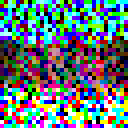

In [113]:
colorview(RGB, Array(out_img))

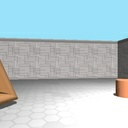

In [122]:
colorview(RGB, permutedims(Array(images[1,10,:,:,:]), (3,1,2)))